In [ ]:
#to-do : refactor the code with pytorch instead of tensorflow

In [2]:
#general
import pandas as pd
import numpy as np
import tensorflow as tf
import wandb
import torch
from wandb.keras import WandbCallback

# EDA
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#feature engineering and data augmentation
#from tabgan.sampler import OriginalGenerator, GANGenerator

#modelling
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.activations import elu
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow_addons.optimizers import RectifiedAdam
from sklearn.metrics import accuracy_score

In [3]:
df= pd.read_csv('./cardio_train.csv',delimiter=';')

# EDA 

In [4]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


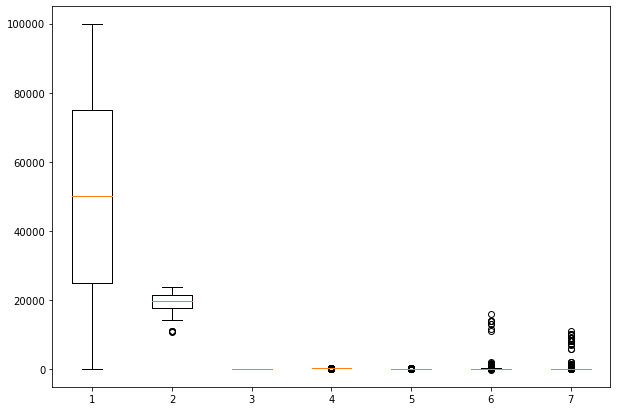

In [25]:
 # Creating dataset
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(df.iloc[:,0:7])
 
# show plot
plt.show()

In [26]:
#profile = ProfileReport(df)
#profile

# Preprocessing

In [8]:
columns_to_drop=['id'] #due to high cardinality

categorical_columns=['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active']

continuous_value_columns=['age','height','weight','ap_hi','ap_lo','cardio']


In [9]:
def preprocessing_p1(df):
    
    #drop id due to high cardinality (id doesn't play a rule since it's arbitrarily assigned)
    try:
        df=df.drop('id', axis=1)
    except:
        pass
    
    #divide age, which is given in days, by 365 to get the year value
    df['age'] = np.round(df['age']/365.25,decimals=2)
    
    #it does not make sense to have gender repersented as 1,2 since the nn would see 2 as bigger (or has more value) than 1
    #we'll change gender into a binary column 
    df['gender'] = df['gender'].replace(2,0)
    
    #drop outliers in height and weight
    df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
    df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
    
    #drop outliers in ap_hi and ap_lo 
    df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
    df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
    
    #we could've converted the BMI into a categorical column but we opted out of that since continuous values have
    #a richer value as an input to the the neural network.    
    df['bmi'] = df['weight'] / (( df['height'] / 100) ** 2)
    
    # at the end we want to drop all duplicate rows
    df.drop_duplicates(inplace=True)
    
    return df 

In [ ]:
# the metadata of the dataset doesn't say which number is assigned to which gender, so we'll assume the gender with higher avg height is the male 
# (we'll take the age to confirm our assumption (avg age for women is higher than men)

#df[df["gender"]==0]["height"].mean() #169.25334163752217
#df[df["gender"]==1]["height"].mean() #162.05207429708628
#df[df["gender"]==0]["age"].mean() #53.07580319072483
#df[df["gender"]==1]["age"].mean() #53.42321937031157

# so we're save to assume that 0 is male and 1 is female

In [6]:
def preprocessing_p2(df):
    
    #applying standard scaling to features
    col_names = ['age', 'height','weight','ap_hi','ap_lo','bmi']
    
    for column in col_names:
        ct = ColumnTransformer([('somename', StandardScaler(), [column])], remainder='passthrough')
        df[column]=ct.fit_transform(df[[column]])

    # one-hot encode categorical columns
    cols_to_one_hot=['gender','cholesterol','gluc','smoke','alco','active'] #bmi
    
    #df = pd.get_dummies(data=df, columns=[col for col in df.columns if col in cols_to_one_hot])
    df = pd.get_dummies(data=df, columns=cols_to_one_hot)

    return df 

In [ ]:
def data_augmentation(dataset):
    
    all_cols=['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
           'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi']

    con= ['age', 'height','weight','ap_hi','ap_lo','bmi']

    categorical=['gender','cholesterol','gluc','smoke','alco','active'] #bmi

    #first try with all , turning binary categories into ordinal categorical 
    #then see if performance increases
    #second: try rounding up to 0 or 1 , or to 2,3
    #binary=['gender','smoke','alc','active']

    age_st= np.std(df.age)
    gender_st=np.std(df.gender)
    height_st=np.std(df.height)
    weight_st=np.std(df.weight)
    ap_hi_st=np.std(df.ap_hi)
    ap_lo_st=np.std(df.ap_lo)
    cholesterol_st=np.std(df.cholesterol)
    gluc_st=np.std(df.gluc)
    smoke_st=np.std(df.smoke)
    alco_st=np.std(df.alco)
    active_st=np.std(df.active)
    cardio_st=np.std(df.cardio)
    bmi_st=np.std(df.bmi)

    dataset=[]

    for _,row in df.iterrows():
        temp={
            'age': row['age'] ,
            'gender': row['gender'],
            'height': row['height'] ,
            'weight': row['weight'] ,
            'ap_hi': row['ap_hi'] ,
            'ap_lo': row['ap_lo'] ,
            'cholesterol': row['cholesterol']  ,
            'gluc': row['gluc'] ,
            'smoke': row['smoke'] ,
            'alco': row['alco'] ,
            'active': row['active'], 
            'cardio': row['cardio'], 
            'bmi': row['bmi'] 
        }
        dataset.append(temp)

    for _ in range(20):
        for _,row in df.iterrows():
            temp={
                'age': row['age'] + np.random.uniform(age_st),
                'gender': row['gender'],
                'height': row['height'] + np.random.uniform(height_st),
                'weight': row['weight'] + np.random.uniform(weight_st),
                'ap_hi': row['ap_hi'] + np.random.uniform(ap_hi_st),
                'ap_lo': row['ap_lo'] + np.random.uniform(ap_lo_st),
                'cholesterol': row['cholesterol'],
                'gluc': row['gluc'] ,
                'smoke': row['smoke'] ,
                'alco': row['alco'] ,
                'active': row['active'],
                'cardio': row['cardio'],
                'bmi': row['bmi'] + np.random.uniform(bmi_st)
            }
            dataset.append(temp)

    print(len(dataset))
    
    return dataset


#deployment

tempy=pd.DataFrame(dataset)

col_names=['age', 'height', 'weight', 'ap_hi', 'ap_lo','bmi']
for column in col_names:
    ct = ColumnTransformer([('somename', StandardScaler(), [column])], remainder='passthrough')
    tempy[column]=ct.fit_transform(tempy[[column]])
    
    
cols_to_one_hot=['gender','cholesterol','gluc','smoke','alco','active']

#df = pd.get_dummies(data=df, columns=[col for col in df.columns if col in cols_to_one_hot])
tempy = pd.get_dummies(data=tempy, columns=cols_to_one_hot)


X = tempy.drop('cardio',axis=1)
y = tempy['cardio'] 

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.05)


In [8]:
### DEPLOY ### 


#applying both processing steps on the dataset 
cpy= preprocessing_p2(preprocessing_p1(pd.read_csv('./cardio_train.csv',delimiter=';')))


#initalize X with our DataFrame - the label we want to predict and assigning the target label to y 
X = cpy.drop('cardio',axis=1)
y = cpy['cardio'] 


#train-test split with the help of sklearn 
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.1)
X_train.head()

#we could've used tf to load the data like:
# df = tf.keras.datasets.<dataset>
# (X_train,y_train),(X_test,y_test) = df.load_data()

,age,height,weight,ap_hi,ap_lo,bmi,gender_0,gender_1,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
28020,-0.129498,1.967765,-0.726264,-0.419613,-0.127124,-1.511623,1,0,1,0,0,0,1,0,1,0,1,0,0,1
58517,0.716510,1.089659,-0.123708,-0.419613,-0.127124,-0.643992,0,1,1,0,0,1,0,0,1,0,1,0,1,0
66338,0.906491,0.504255,-0.726264,-0.419613,-0.127124,-0.940762,1,0,1,0,0,1,0,0,1,0,1,0,0,1
21388,-0.162151,-0.959255,-0.726264,-1.145936,-1.340201,-0.258112,0,1,1,0,0,1,0,0,1,0,1,0,1,0
54978,-1.092759,-0.520202,-0.898423,-1.872258,-1.340201,-0.651451,1,0,1,0,0,1,0,0,0,1,1,0,0,1


# Modelling

In [38]:
model = Sequential()

#model.add(Dense(units=16, activation='elu', input_dim=X_train.shape[1]))

model.add(Dense(units=32,input_dim=X_train.shape[1]))
model.add(Activation('tanh'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(units=32))
model.add(Activation('tanh'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(units=32))
model.add(Activation('tanh'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(units=32))
model.add(Activation('tanh'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(units=1))
model.add(Activation('sigmoid'))

optimizer=SGD(learning_rate= 0.01, momentum=0.5)
loss = BinaryCrossentropy(label_smoothing = 0.1)
#optimizer= CosineDecay()
model.compile(loss=loss, optimizer=optimizer, metrics= 'accuracy')

# > Dense -> BatchNorm -> ReLu(or other activation) -> Dropout -> Dense ->

In [ ]:
wandb.init(project='cardiovascular-disease-detection',config={'epochs':200,'batch_size':16})

model.fit(X_train,y_train, epochs=wandb.config.epochs, batch_size=wandb.config.batch_size, callbacks=[wandb.keras.WandbCallback()])

accuracy,▁▇▇▇▇█▇█▇
epoch,▁▂▃▄▅▅▆▇█
loss,█▂▁▁▁▁▁▁▁
accuracy,0.71467
epoch,8
loss,0.59922


Epoch 1/200
74896/74896 [==============================] - 80s 1ms/step - loss: 0.6190 - accuracy: 0.6986
Epoch 2/200
74896/74896 [==============================] - 76s 1ms/step - loss: 0.6111 - accuracy: 0.7020
Epoch 3/200
74896/74896 [==============================] - 76s 1ms/step - loss: 0.6081 - accuracy: 0.7025
Epoch 4/200
74896/74896 [==============================] - 76s 1ms/step - loss: 0.6067 - accuracy: 0.7036
Epoch 5/200
74896/74896 [==============================] - 77s 1ms/step - loss: 0.6060 - accuracy: 0.7046
Epoch 6/200
74896/74896 [==============================] - 75s 1ms/step - loss: 0.6052 - accuracy: 0.7055
Epoch 7/200
74896/74896 [==============================] - 75s 995us/step - loss: 0.6047 - accuracy: 0.7061
Epoch 8/200
74896/74896 [==============================] - 75s 1ms/step - loss: 0.6042 - accuracy: 0.7069
Epoch 9/200
74896/74896 [==============================] - 75s 1ms/step - loss: 0.6038 - accuracy: 0.7077
Epoch 10/200
74896/74896 [==================

In [ ]:
#model.evaluate(X_test,y_test)

#prediction and saving model 

#y_hat=model.predict(X_test)
#y_hat=[0 if val<0.5 else 1 for val in y_hat]
#accuracy_score(y_test,y_hat)

#model.save('<nameoffolder>')
#model.load('<nameofmodel>')

# Data Augmentation to improve model acc

In [ ]:
#check above (before "Modelling")

### Creating Synthetic Data Using GANs

In [ ]:
# random input data
np.random.seed(0)
train = pd.DataFrame(np.random.randint(-10, 150, size=(150, 4)), columns=list("ABCD"))
target = pd.DataFrame(np.random.randint(0, 2, size=(150, 1)), columns=list("Y"))
test = pd.DataFrame(np.random.randint(0, 100, size=(100, 4)), columns=list("ABCD"))

# generate data
#new_train1, new_target1 = OriginalGenerator().generate_data_pipe(train, target, test, )
new_train, new_target = GANGenerator().generate_data_pipe(train, target, test,)
#df_merged = a.append(b, ignore_index=True)


Fitting CTGAN transformers for each column:   0%|          | 0/5 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\marka\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\marka\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\marka\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument ins

In [ ]:
copy=preprocessing_p1(df)

X = copy.drop('cardio',axis=1)
y = copy['cardio'] 
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.1)

y_train= y_train.to_frame(name='cardio')


new_train, new_target = GANGenerator().generate_data_pipe(X_train, y_train, X_test)

new_target= new_target.to_frame(name='cardio')

X_train=X_train.append(new_train, ignore_index=True)
y_train=y_train.append(new_target, ignore_index=True)

X_train = preprocessing_p2(X_train)


In [ ]:
import ctgan
import pandas as pd 
import numpy as np

from ctgan import CTGAN
from ctgan import load_demo

real_data = preprocessing_p1(df)

list(real_data.columns)

ctgan = CTGAN(epochs=10)
ctgan.fit(real_data, list(real_data.columns)
)

# Create synthetic data

synthetic_data = ctgan.sample(10000)

KeyboardInterrupt: 